ЛАБОРАТОРНАЯ РАБОТА ПО ОБРАБОТКЕ ИЗОБРАЖЕНИЙ #2
 
1. Зашумить изображение при помощи шума гаусса, постоянного шума.
-----------------------------------------------------------------


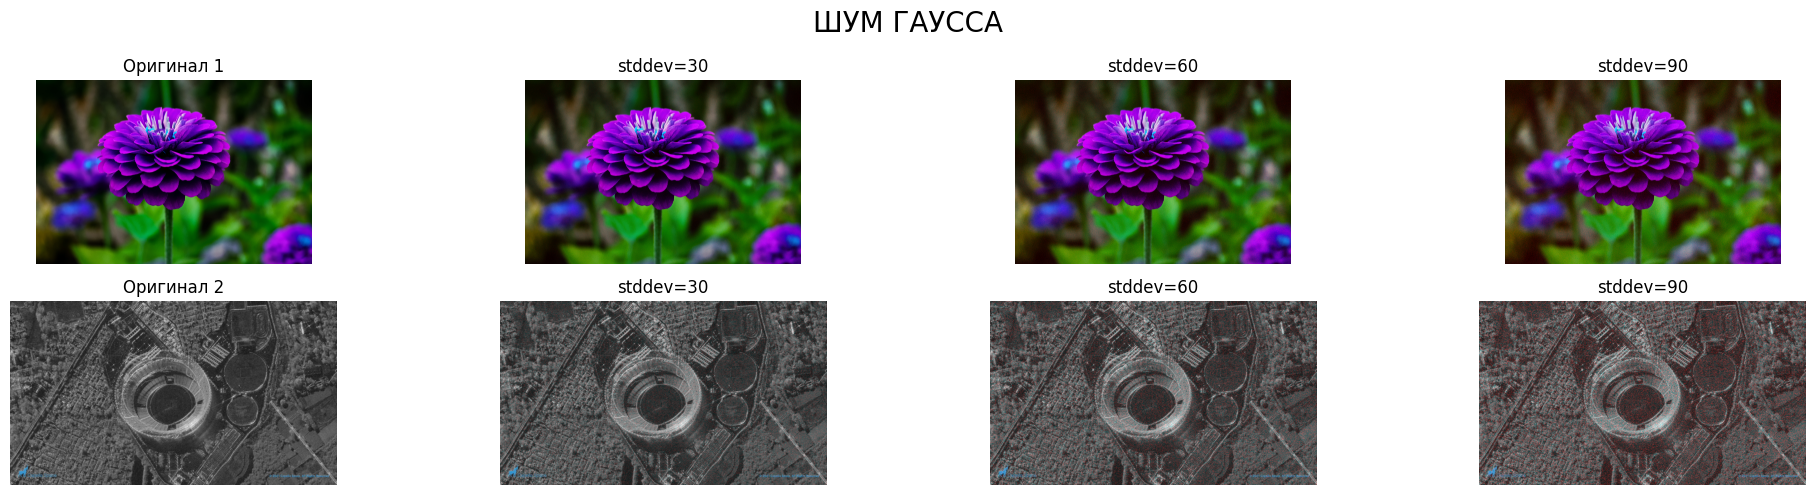

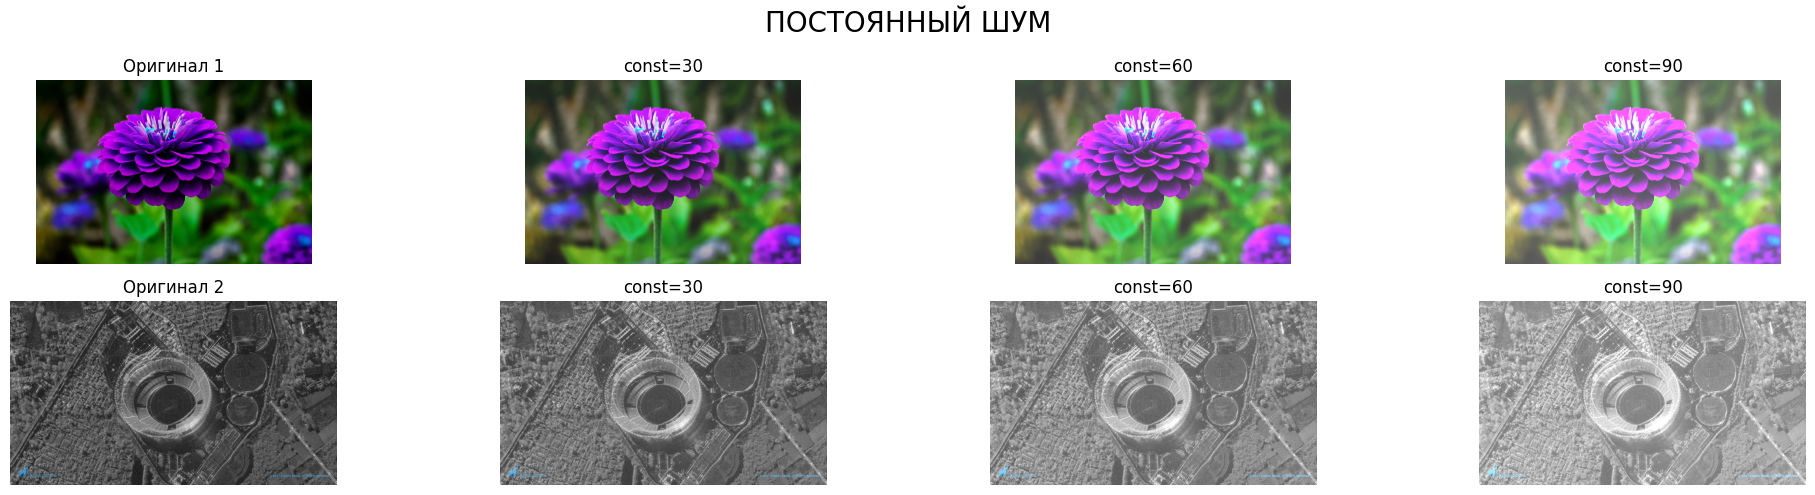

 
 
2. Протестировать медианный фильтр, фильтр гаусса, билатериальный фильтр,
 фильтр нелокальных средних с различными параметрами.
----------------------------------------------------------------------------------------
1 строка - оригиналы изображений 
2 строка - медианный фильтр 
3 строка - фильтр Гаусса 
4 строка - билатеральный фильтр 
5 строка - фильтр нелокальных средних


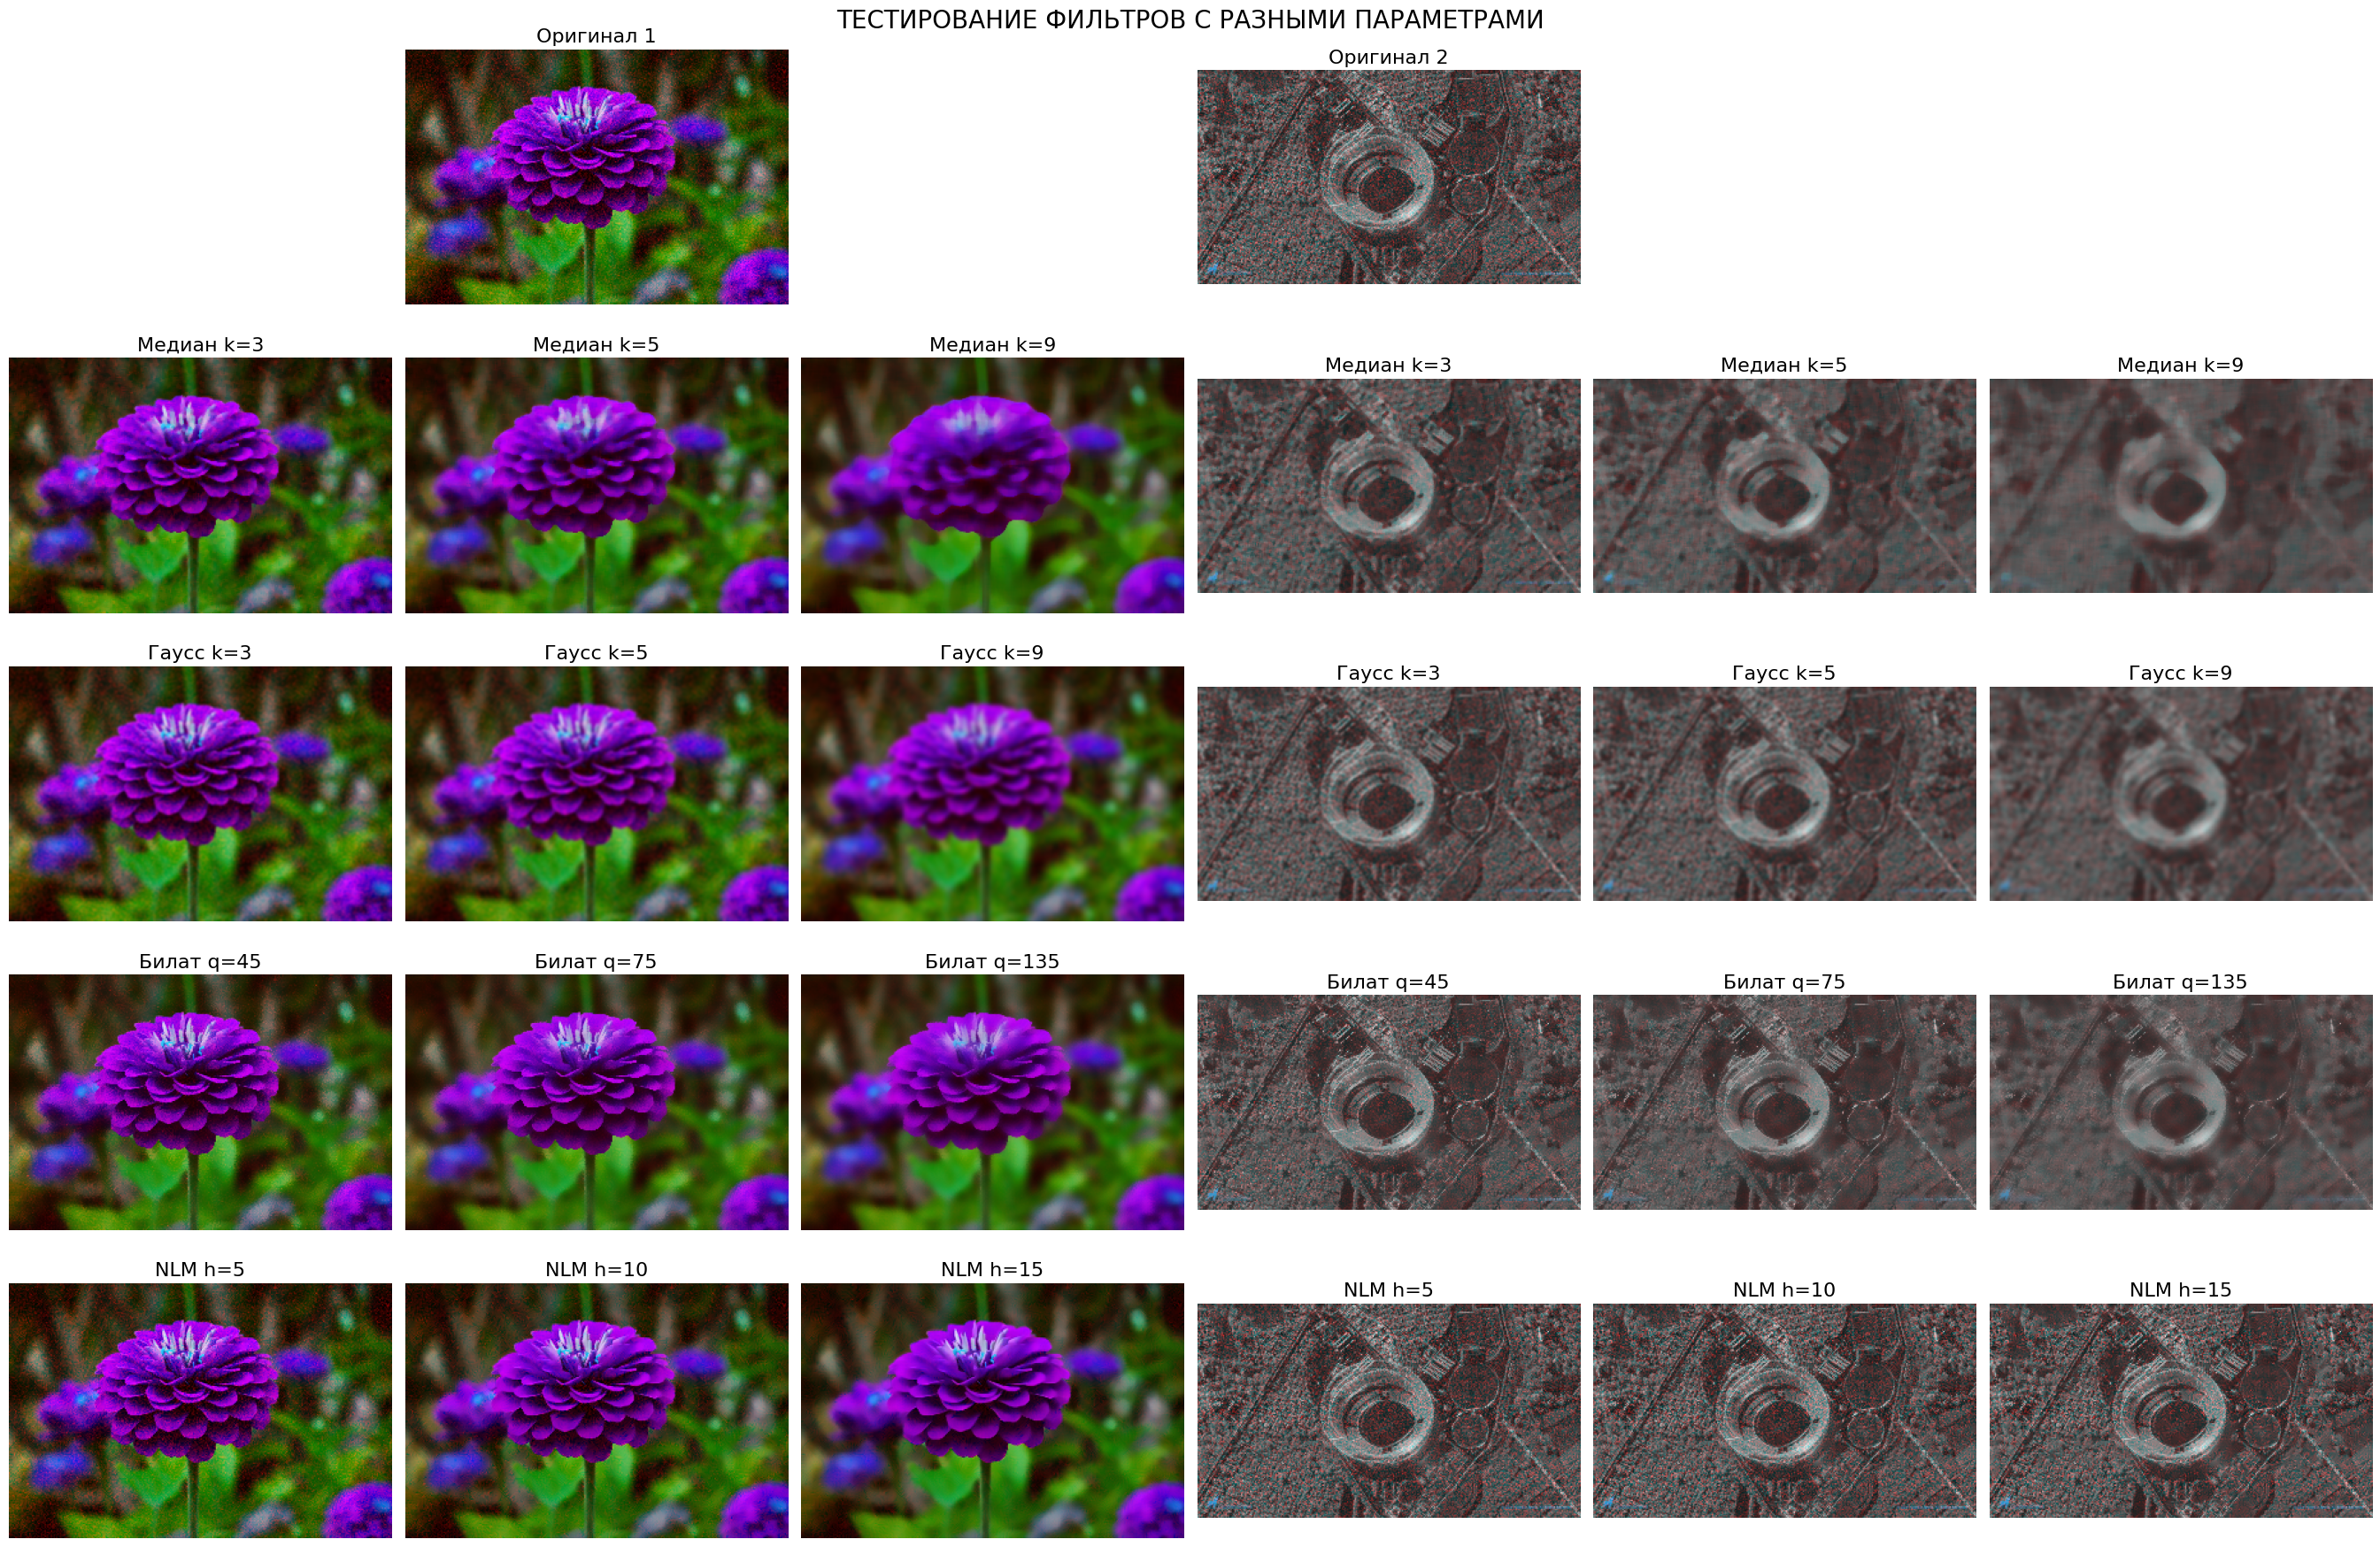

 
 
3. Выяснить, какой фильтр показал лучший результат фильтрации шума.
----------------------------------------------------------------------------------------
Оптимальный фильтр по критерию MSE: Метод: NLM h=5
MSE: 10.60 (минимальное значение предпочтительнее)
SSIM: 0.9691

Оптимальный фильтр по критерию SSIM: Метод: NLM h=5
MSE: 10.60
SSIM: 0.9691 (максимальное значение предпочтительнее)

Результаты всех фильтров:
Медианный k=3: MSE=370.97, SSIM=0.8994
Гаусс k=3: MSE=266.14, SSIM=0.9205
Билатеральный q=45: MSE=111.58, SSIM=0.9523
NLM h=5: MSE=10.60, SSIM=0.9691
Медианный k=5: MSE=441.15, SSIM=0.8612
Гаусс k=5: MSE=348.48, SSIM=0.8894
Билатеральный q=75: MSE=223.45, SSIM=0.9160
NLM h=10: MSE=103.61, SSIM=0.9319
Медианный k=9: MSE=586.49, SSIM=0.7726
Гаусс k=9: MSE=461.99, SSIM=0.8340
Билатеральный q=135: MSE=338.79, SSIM=0.8721
NLM h=15: MSE=234.63, SSIM=0.9038


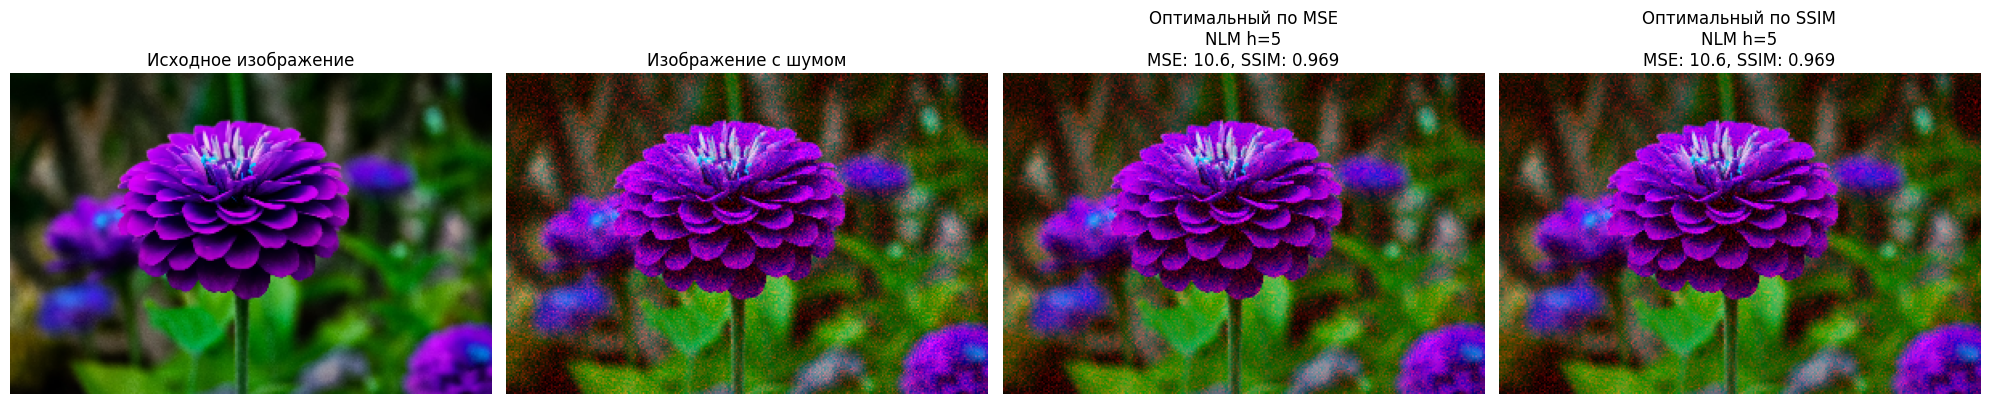

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import os

print("="*51)
print("ЛАБОРАТОРНАЯ РАБОТА ПО ОБРАБОТКЕ ИЗОБРАЖЕНИЙ #2")
print("="*51)
print(" ")
img = cv2.imread('img.jpg')
img_wb = cv2.imread('img_wb.jpg')


###1 ЗАДАНИЕ : Зашумить изображение при помощи шума гаусса, постоянного шума.
print("1. Зашумить изображение при помощи шума гаусса, постоянного шума.")
print("-"*65)

stddev = [30, 60, 90]
mean = 0

def gauss(x, mean, sigma):
    noise = np.zeros(x.shape, dtype=np.float32)
    cv2.randn(noise, mean, sigma)
    noisy_image = x.astype(np.float32) + noise     # Добавляем шум к исходному изображению
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image.astype(np.uint8)

def constant(image, constant_value):
    noisy_image = image.astype(np.float32) + constant_value
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image.astype(np.uint8)


plt.figure(figsize=(20, 5))
# Оригиналы
plt.subplot(2, 4, 1)
plt.imshow(img)
plt.title("Оригинал 1")
plt.axis("off")

plt.subplot(2, 4, 5)
plt.imshow(img_wb)
plt.title("Оригинал 2")
plt.axis("off")

for i in range(len(stddev)):
    # шум для img
    ng1 = gauss(img, mean, stddev[i])
    plt.subplot(2, 4, i+2)
    plt.imshow(ng1, cmap="gray")
    plt.title(f"stddev={stddev[i]}")
    plt.axis('off')

    # шум для img_wb
    ng2 = gauss(img_wb, mean, stddev[i])
    plt.subplot(2, 4, i+6)
    plt.imshow(ng2, cmap="gray")
    plt.title(f"stddev={stddev[i]}")
    plt.axis('off')

#для 2 задания
img_n1 = ng1
img_n2 = ng2

plt.suptitle("ШУМ ГАУССА", fontsize=20)
plt.tight_layout()
plt.show()
print(" ")


plt.figure(figsize=(20, 5))
# Оригиналы
plt.subplot(2, 4, 1)
plt.imshow(img)
plt.title("Оригинал 1")
plt.axis("off")

plt.subplot(2, 4, 5)
plt.imshow(img_wb)
plt.title("Оригинал 2")
plt.axis("off")

for i in range(len(stddev)):
    # постоянный шум для img
    ng1 = constant(img, stddev[i])
    plt.subplot(2, 4, i+2)
    plt.imshow(ng1)
    plt.title(f"const={stddev[i]}")
    plt.axis('off')

    # постоянный шум для img_wb
    ng2 = constant(img_wb, stddev[i])
    plt.subplot(2, 4, i+6)
    plt.imshow(ng2, cmap="gray")
    plt.title(f"const={stddev[i]}")
    plt.axis('off')

plt.suptitle("ПОСТОЯННЫЙ ШУМ", fontsize=20)
plt.tight_layout()
plt.show()
print(" ")
print(" ")



###2 ЗАДАНИЕ : Протестировать медианный фильтр, фильтр гаусса, билатериальный фильтр, фильтр нелокальных средних с различными параметрами.
print("2. Протестировать медианный фильтр, фильтр гаусса, билатериальный фильтр,\n фильтр нелокальных средних с различными параметрами.")
print("-"*88)
print("1 строка - оригиналы изображений \n2 строка - медианный фильтр \n3 строка - фильтр Гаусса \n4 строка - билатеральный фильтр \n5 строка - фильтр нелокальных средних")

plt.figure(figsize=(27, 18))

def resize_for_processing(image, max_size=300):
    h, w = image.shape[:2]
    if max(h, w) > max_size:
        scale = max_size / max(h, w)
        new_h, new_w = int(h * scale), int(w * scale)
        return cv2.resize(image, (new_w, new_h))
    return image

# Подготавливаем изображения
img_small = resize_for_processing(img_n1)
img_wb_small = resize_for_processing(img_n2)

# Приводим к uint8
if img_small.dtype != 'uint8':
    img_small = (img_small * 255).astype('uint8')
if img_wb_small.dtype != 'uint8':
    img_wb_small = (img_wb_small * 255).astype('uint8')

# Параметры для фильтров (только нечетные для медианного фильтра)
k = [3, 5, 9]

# Первая строка - оригиналы
plt.subplot(5, 6, 2)
plt.imshow(img_small)
plt.title("Оригинал 1", fontsize=16)
plt.axis("off")

plt.subplot(5, 6, 4)
plt.imshow(img_wb_small, cmap="gray")
plt.title("Оригинал 2", fontsize=16)
plt.axis("off")

# Вторая строка - медианный фильтр
for i in range(len(k)):
    m1 = cv2.medianBlur(img_small, k[i])
    plt.subplot(5, 6, i+7)
    plt.imshow(m1)
    plt.title(f"Медиан k={k[i]}", fontsize=16)
    plt.axis('off')

    m2 = cv2.medianBlur(img_wb_small, k[i])
    plt.subplot(5, 6, i+10)
    plt.imshow(m2, cmap="gray")
    plt.title(f"Медиан k={k[i]}", fontsize=16)
    plt.axis('off')

# Третья строка - фильтр Гаусса
for i in range(len(k)):
    g1 = cv2.GaussianBlur(img_small, (k[i], k[i]), 0)
    plt.subplot(5, 6, i+13)
    plt.imshow(g1)
    plt.title(f"Гаусс k={k[i]}", fontsize=16)
    plt.axis('off')

    g2 = cv2.GaussianBlur(img_wb_small, (k[i], k[i]), 0)
    plt.subplot(5, 6, i+16)
    plt.imshow(g2, cmap="gray")
    plt.title(f"Гаусс k={k[i]}", fontsize=16)
    plt.axis('off')

# Четвертая строка - билатеральный фильтр
for i in range(len(k)):
    b1 = cv2.bilateralFilter(img_small, 9, k[i]*15, k[i]*15)
    plt.subplot(5, 6, i+19)
    plt.imshow(b1)
    plt.title(f"Билат q={k[i]*15}", fontsize=16)
    plt.axis('off')

    b2 = cv2.bilateralFilter(img_wb_small, 9, k[i]*15, k[i]*15)
    plt.subplot(5, 6, i+22)
    plt.imshow(b2, cmap="gray")
    plt.title(f"Билат q={k[i]*15}", fontsize=16)
    plt.axis('off')

# Пятая строка - фильтр нелокальных средних
nl_params = [5, 10, 15]  # h параметры для NLM
for i in range(len(k)):
    # Для цветного изображения - используем более быстрые параметры
    f1 = cv2.fastNlMeansDenoisingColored(img_small, None, nl_params[i], nl_params[i], 3, 7)
    plt.subplot(5, 6, i+25)
    plt.imshow(f1)
    plt.title(f"NLM h={nl_params[i]}", fontsize=16)
    plt.axis('off')

    # Для ч/б изображения
    f2 = cv2.fastNlMeansDenoising(img_wb_small, None, nl_params[i], 3, 7)
    plt.subplot(5, 6, i+28)
    plt.imshow(f2, cmap="gray")
    plt.title(f"NLM h={nl_params[i]}", fontsize=16)
    plt.axis('off')

plt.suptitle("ТЕСТИРОВАНИЕ ФИЛЬТРОВ С РАЗНЫМИ ПАРАМЕТРАМИ", fontsize=20)
plt.tight_layout()
plt.show()
print(" ")
print(" ")



###3 ЗАДАНИЕ : Выяснить, какой фильтр показал лучший результат фильтрации шума.
print("3. Выяснить, какой фильтр показал лучший результат фильтрации шума.")
print("-"*88)

def calculate_metrics(original, filtered):
    mse = np.mean((original.astype(float) - filtered.astype(float)) ** 2)

    if len(original.shape) == 3:
        original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
        filtered_gray = cv2.cvtColor(filtered, cv2.COLOR_BGR2GRAY)
    else:
        original_gray = original
        filtered_gray = filtered

    ssim = structural_similarity(original_gray, filtered_gray)
    return mse, ssim

# Подготавливаем изображения для сравнения (используем исходное изображение из 2 задания)
img_original = img_small
img_noisy = img_small

# Применяем различные фильтры и вычисляем метрики
filter_results = {}

# Используем изображения из второго задания
# Медианный фильтр с разными параметрами (из 2 задания)
median_images = []
gauss_images = []
bilateral_images = []
nlm_images = []

for i in range(len(k)):
    # Медианный фильтр
    m1 = cv2.medianBlur(img_small, k[i])
    median_images.append(m1)

    # Фильтр Гаусса
    g1 = cv2.GaussianBlur(img_small, (k[i], k[i]), 0)
    gauss_images.append(g1)

    # Билатеральный фильтр
    b1 = cv2.bilateralFilter(img_small, 9, k[i]*15, k[i]*15)
    bilateral_images.append(b1)

    # Фильтр нелокальных средних
    f1 = cv2.fastNlMeansDenoisingColored(img_small, None, nl_params[i], nl_params[i], 3, 7)
    nlm_images.append(f1)

# Вычисляем метрики для всех сохраненных изображений
for i, k_size in enumerate(k):
    # Медианный фильтр
    mse, ssim = calculate_metrics(img_small, median_images[i])
    filter_results[f'Медианный k={k_size}'] = {
        'image': median_images[i],
        'mse': mse,
        'ssim': ssim
    }

    # Фильтр Гаусса
    mse, ssim = calculate_metrics(img_small, gauss_images[i])
    filter_results[f'Гаусс k={k_size}'] = {
        'image': gauss_images[i],
        'mse': mse,
        'ssim': ssim
    }

    # Билатеральный фильтр
    mse, ssim = calculate_metrics(img_small, bilateral_images[i])
    filter_results[f'Билатеральный q={k_size*15}'] = {
        'image': bilateral_images[i],
        'mse': mse,
        'ssim': ssim
    }

    # Фильтр нелокальных средних
    mse, ssim = calculate_metrics(img_small, nlm_images[i])
    filter_results[f'NLM h={nl_params[i]}'] = {
        'image': nlm_images[i],
        'mse': mse,
        'ssim': ssim
    }

def select_optimal_filter_by_mse(filter_results):
    optimal_filter = None

    for method_name, metrics in filter_results.items():
        current_mse = metrics['mse']
        current_ssim = metrics['ssim']

        if optimal_filter is None:
            optimal_filter = {
                'method': method_name,
                'filtered_image': metrics['image'],
                'mse_value': current_mse,
                'ssim_value': current_ssim
            }
        elif current_mse < optimal_filter['mse_value']:
            optimal_filter = {
                'method': method_name,
                'filtered_image': metrics['image'],
                'mse_value': current_mse,
                'ssim_value': current_ssim
            }
        elif current_mse == optimal_filter['mse_value']:
            if current_ssim > optimal_filter['ssim_value']:
                optimal_filter = {
                    'method': method_name,
                    'filtered_image': metrics['image'],
                    'mse_value': current_mse,
                    'ssim_value': current_ssim
                }

    return optimal_filter

def select_optimal_filter_by_ssim(filter_results):
    optimal_filter = None

    for method_name, metrics in filter_results.items():
        current_mse = metrics['mse']
        current_ssim = metrics['ssim']

        if optimal_filter is None or current_ssim > optimal_filter['ssim_value']:
            optimal_filter = {
                'method': method_name,
                'filtered_image': metrics['image'],
                'mse_value': current_mse,
                'ssim_value': current_ssim
            }
        elif current_ssim == optimal_filter['ssim_value'] and current_mse < optimal_filter['mse_value']:
            optimal_filter = {
                'method': method_name,
                'filtered_image': metrics['image'],
                'mse_value': current_mse,
                'ssim_value': current_ssim
            }

    return optimal_filter

# Находим лучшие фильтры по каждой метрике
top_mse_filter = select_optimal_filter_by_mse(filter_results)
top_ssim_filter = select_optimal_filter_by_ssim(filter_results)

print(f"Оптимальный фильтр по критерию MSE: Метод: {top_mse_filter['method']}")
print(f"MSE: {top_mse_filter['mse_value']:.2f} (минимальное значение предпочтительнее)")
print(f"SSIM: {top_mse_filter['ssim_value']:.4f}")

print(f"\nОптимальный фильтр по критерию SSIM: Метод: {top_ssim_filter['method']}")
print(f"MSE: {top_ssim_filter['mse_value']:.2f}")
print(f"SSIM: {top_ssim_filter['ssim_value']:.4f} (максимальное значение предпочтительнее)")

# Выводим результаты всех фильтров построчно
print("\nРезультаты всех фильтров:")
print("=" * 40)
for method, metrics in filter_results.items():
    print(f"{method}: MSE={metrics['mse']:.2f}, SSIM={metrics['ssim']:.4f}")
print("=" * 40)

# Визуализация результатов
plt.figure(figsize=(20, 16))

plt.subplot(1, 4, 1)
plt.imshow(resize_for_processing(img), cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img_small, cmap='gray')
plt.title('Изображение с шумом')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(top_mse_filter['filtered_image'], cmap='gray')
plt.title(f'Оптимальный по MSE\n{top_mse_filter["method"]}\nMSE: {top_mse_filter["mse_value"]:.1f}, SSIM: {top_mse_filter["ssim_value"]:.3f}')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(top_ssim_filter['filtered_image'], cmap='gray')
plt.title(f'Оптимальный по SSIM\n{top_ssim_filter["method"]}\nMSE: {top_ssim_filter["mse_value"]:.1f}, SSIM: {top_ssim_filter["ssim_value"]:.3f}')
plt.axis('off')

plt.tight_layout()
plt.show()
print(" ")